In [1]:
%pylab inline
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
safety_factor = 1.5
aircraft_weight = 1050

# force encountered per landing gear
landing_force = (4.45*aircraft_weight * safety_factor) / 2

In [3]:
# stress analysis of curved beam
# parameters
top_length = 0.800
bot_length = 0.190

curved_area = 0.020 * 0.070

# https://courses.washington.edu/me354a/Curved%20Beams.pdf
section_depth = 0.020
outer_radius = 0.070
inner_radius = 0.050

neutral_axis_radius = section_depth / (np.log(outer_radius/inner_radius))   # r
centroidal_axis_radius = inner_radius + section_depth / 2                   # r bar

In [4]:
# stress distributions of curved section
def inner_normal_stress(moment, loc):
    return (moment * loc) / (curved_area * (centroidal_axis_radius - neutral_axis_radius) * inner_radius)

def outer_normal_stress(moment, loc):
    return (moment * loc) / (curved_area * (centroidal_axis_radius - neutral_axis_radius) * outer_radius)

In [5]:
moment = 0.020 * landing_force
max_inner_stress = inner_normal_stress(moment, neutral_axis_radius - inner_radius)
max_outer_stress = outer_normal_stress(moment, outer_radius - neutral_axis_radius)

print('Maximum inner stress: ', np.round(max_inner_stress/1e6, decimals=2), ' MPa')
print('Maximum outer stress: ', np.round(max_outer_stress/1e6, decimals=2), ' MPa')

Maximum inner stress:  16.89  MPa
Maximum outer stress:  13.49  MPa


In [6]:
moment2 = top_length * landing_force
max_inner_stress2 = inner_normal_stress(moment2, neutral_axis_radius - inner_radius) - landing_force/curved_area
max_outer_stress2 = outer_normal_stress(moment2, outer_radius - neutral_axis_radius) - landing_force/curved_area

print('Maximum inner stress: ', np.round(max_inner_stress2/1e6, decimals=2), ' MPa')
print('Maximum outer stress: ', np.round(max_outer_stress2/1e6, decimals=2), ' MPa')

Maximum inner stress:  672.97  MPa
Maximum outer stress:  537.19  MPa


## Stress Analysis Along Top Bar
Due to the taper, the stress in this area will vary non-linearly

In [7]:
num_points = 250

x_vec = np.linspace(0, 0.742, num=num_points)
beam_width = np.linspace(0.070, 0.150, num=num_points)

shear = np.ones(num_points) * landing_force
moment = x_vec * landing_force

beam_inertia = (1/12) * beam_width * np.power(0.020, 3)

beam_stress = (moment * 0.020/2) / beam_inertia

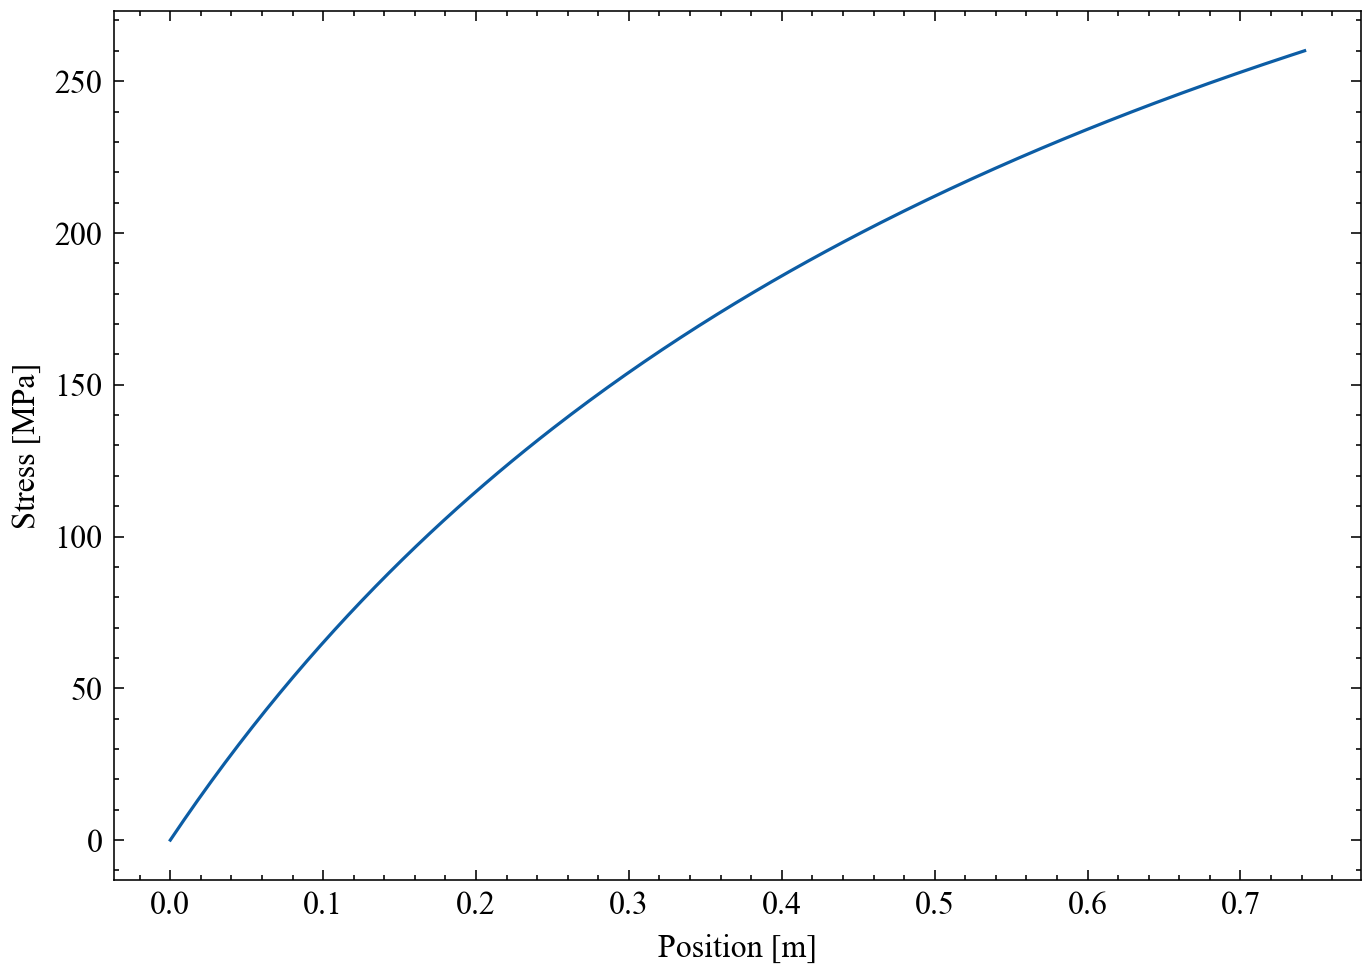

In [8]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.plot(x_vec, beam_stress/1e6)

plt.xlabel('Position [m]')
plt.ylabel('Stress [MPa]')

plt.show()
max_beam_stress = beam_stress[-1]

In [9]:
mat_density = 7880
mat_yield = 758e6
mat_tensile = 1034e6

## Fatigue Analysis

In [10]:
load_factor = 1
grad_factor = 0.9
surf_factor = 0.78
temp_factor = 1
reli_factor = 1

endurance_limit = load_factor * grad_factor * surf_factor * temp_factor * reli_factor * 0.5*mat_tensile

print('Endurance limit: ', np.round(endurance_limit/1e6, decimals=2), ' Mpa')

Endurance limit:  362.93  Mpa


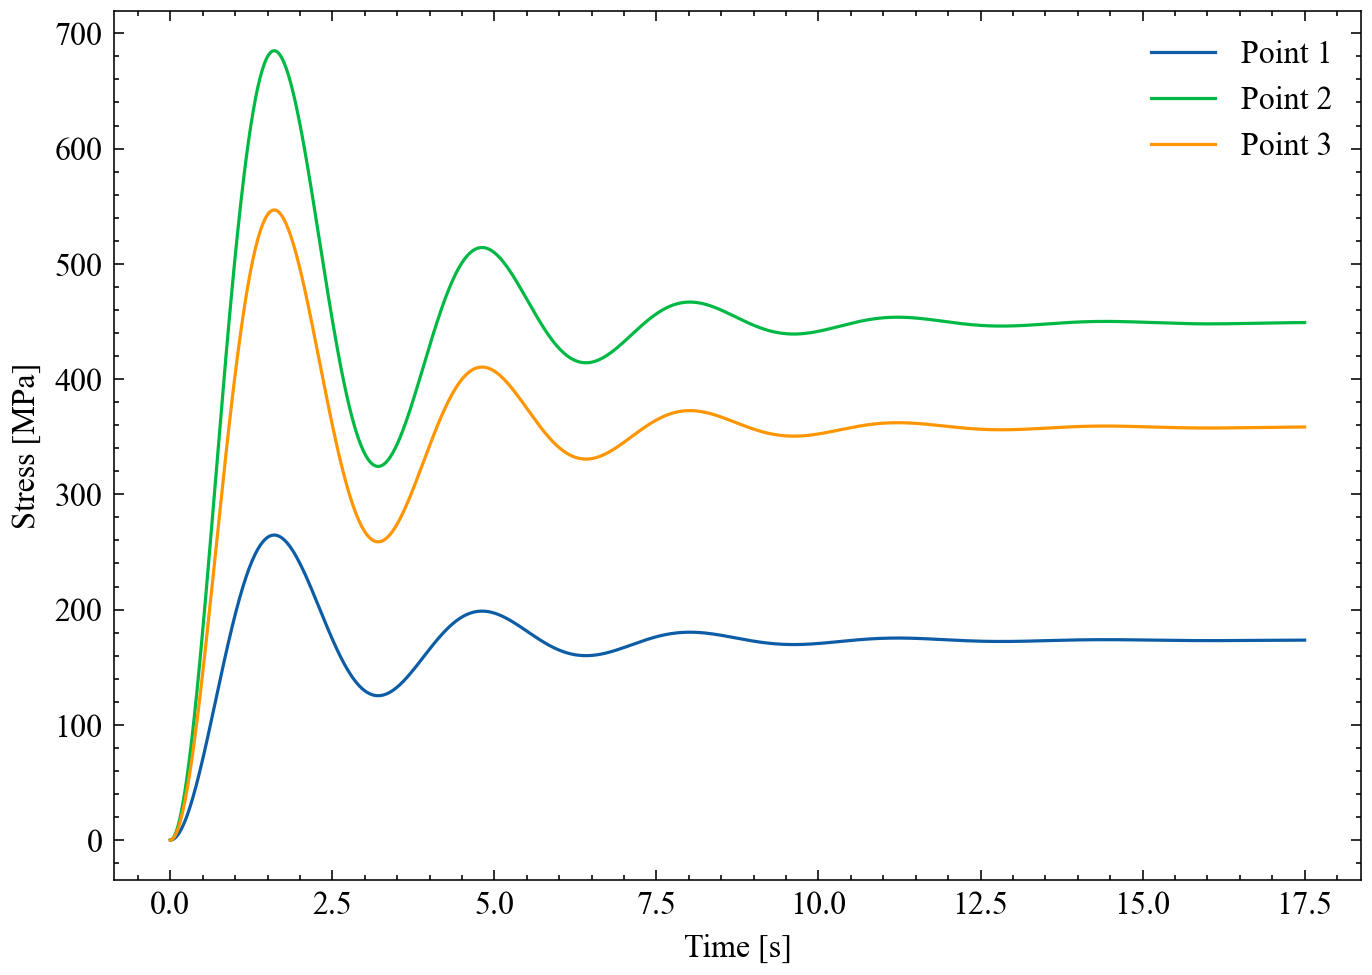

In [11]:
plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

sigma1 = signal.lti([max_beam_stress/(1.5*1e6)], [0.25, 0.20, 1.0])
t1, y1 = signal.step(sigma1, N=1000)

sigma2 = signal.lti([max_inner_stress2/(1.5*1e6)], [0.25, 0.20, 1.0])
t2, y2 = signal.step(sigma2, N=1000)

sigma3 = signal.lti([max_outer_stress2/(1.5*1e6)], [0.25, 0.20, 1.0])
t3, y3 = signal.step(sigma3, N=1000)

plt.plot(t1, y1, label='Point 1')
plt.plot(t2, y2, label='Point 2')
plt.plot(t3, y3, label='Point 3')

plt.xlabel('Time [s]')
plt.ylabel('Stress [MPa]')

plt.legend()
plt.show()

In [12]:
p1_mean_stress = ((max_beam_stress)/2)
p1_max_stress = max_beam_stress
p1_min_stress = 0

p1_stress_m = (p1_max_stress + p1_min_stress)/2
p1_stress_a = (p1_max_stress - p1_min_stress)/2

p2_mean_stress = max_inner_stress2/2
p2_max_stress = max_inner_stress2
p2_min_stress = 0

p2_stress_m = (p2_max_stress + p2_min_stress)/2
p2_stress_a = (p2_max_stress - p2_min_stress)/2

p3_mean_stress = max_outer_stress2/2
p3_max_stress = max_outer_stress2
p3_min_stress = 0

p3_stress_m = (p3_max_stress + p3_min_stress)/2
p3_stress_a = (p3_max_stress - p3_min_stress)/2

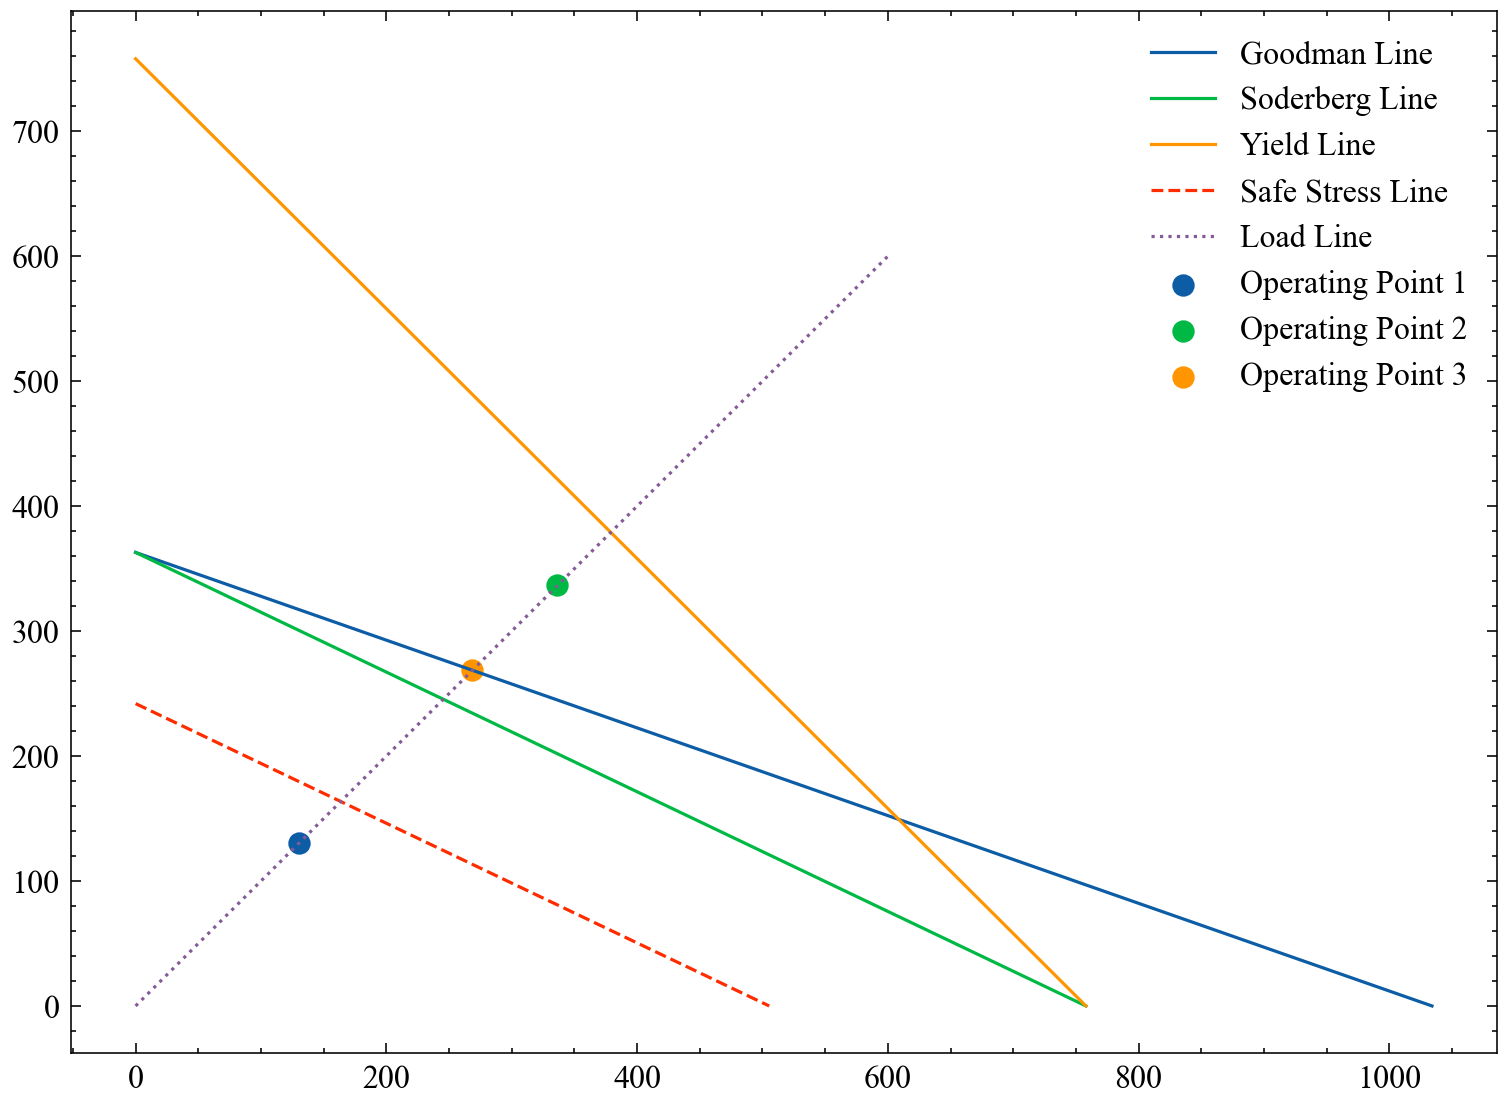

In [13]:
plt.figure(dpi=230, figsize=(8,6))
plt.style.use(['science', 'no-latex'])

plt.plot([0, mat_tensile/1e6], [endurance_limit/1e6, 0], label='Goodman Line')
plt.plot([0, mat_yield/1e6], [endurance_limit/1e6, 0], label='Soderberg Line')
plt.plot([0, mat_yield/1e6], [mat_yield/1e6, 0], label='Yield Line')
plt.plot([0, (mat_yield/1e6)/1.5], [(endurance_limit/1e6)/1.5, 0], label='Safe Stress Line', linestyle='--')

x = np.linspace(0, 600)
y = (p1_stress_a/p1_stress_m)*x

plt.plot(x, y, label='Load Line', linestyle=':')
plt.scatter(p1_stress_m/1e6, p1_stress_a/1e6, label='Operating Point 1')
plt.scatter(p2_stress_m/1e6, p2_stress_a/1e6, label='Operating Point 2')
plt.scatter(p3_stress_m/1e6, p3_stress_a/1e6, label='Operating Point 3')

plt.legend()
plt.show()